In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier

The Titanic dataset is a classification problem because we are creating a model to predict whether a passenger survived or not.
Specifically, this is a binary classification problem because there are only 2 options to consider: survived or not.  Under the Survived column, 0 stands for didn't survive and 1 means survived.

In [3]:
train_dat = pd.read_csv('titanic/train.csv')
test_dat = pd.read_csv('titanic/test.csv')

In [4]:
train_dat.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_dat.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
print('Training set shape:', train_dat.shape)
print('Testing set shape: ', test_dat.shape)

Training set shape: (891, 12)
Testing set shape:  (418, 11)


Exploratory Data Analysis

Exploratory data analysis is conducted on the dataset before a model is created to get an idea visually of what the data can tell us, i.e., the number of survivors in each class. 

In [7]:
train_dat.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The heatmap shows that there is a strong correlation between the columns Pclass and Survived.  The below bar plot shows that as far as Pclass is concerned the largest group that didn't survive were in 3rd class.

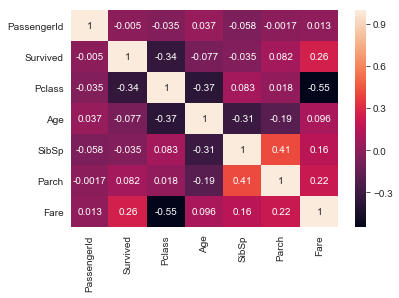

In [8]:
sns.heatmap(train_dat.corr(), annot=True);

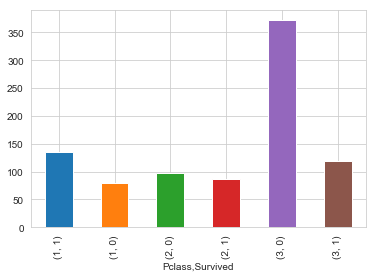

In [9]:
train_dat.groupby('Pclass')['Survived'].value_counts().plot(kind='bar');

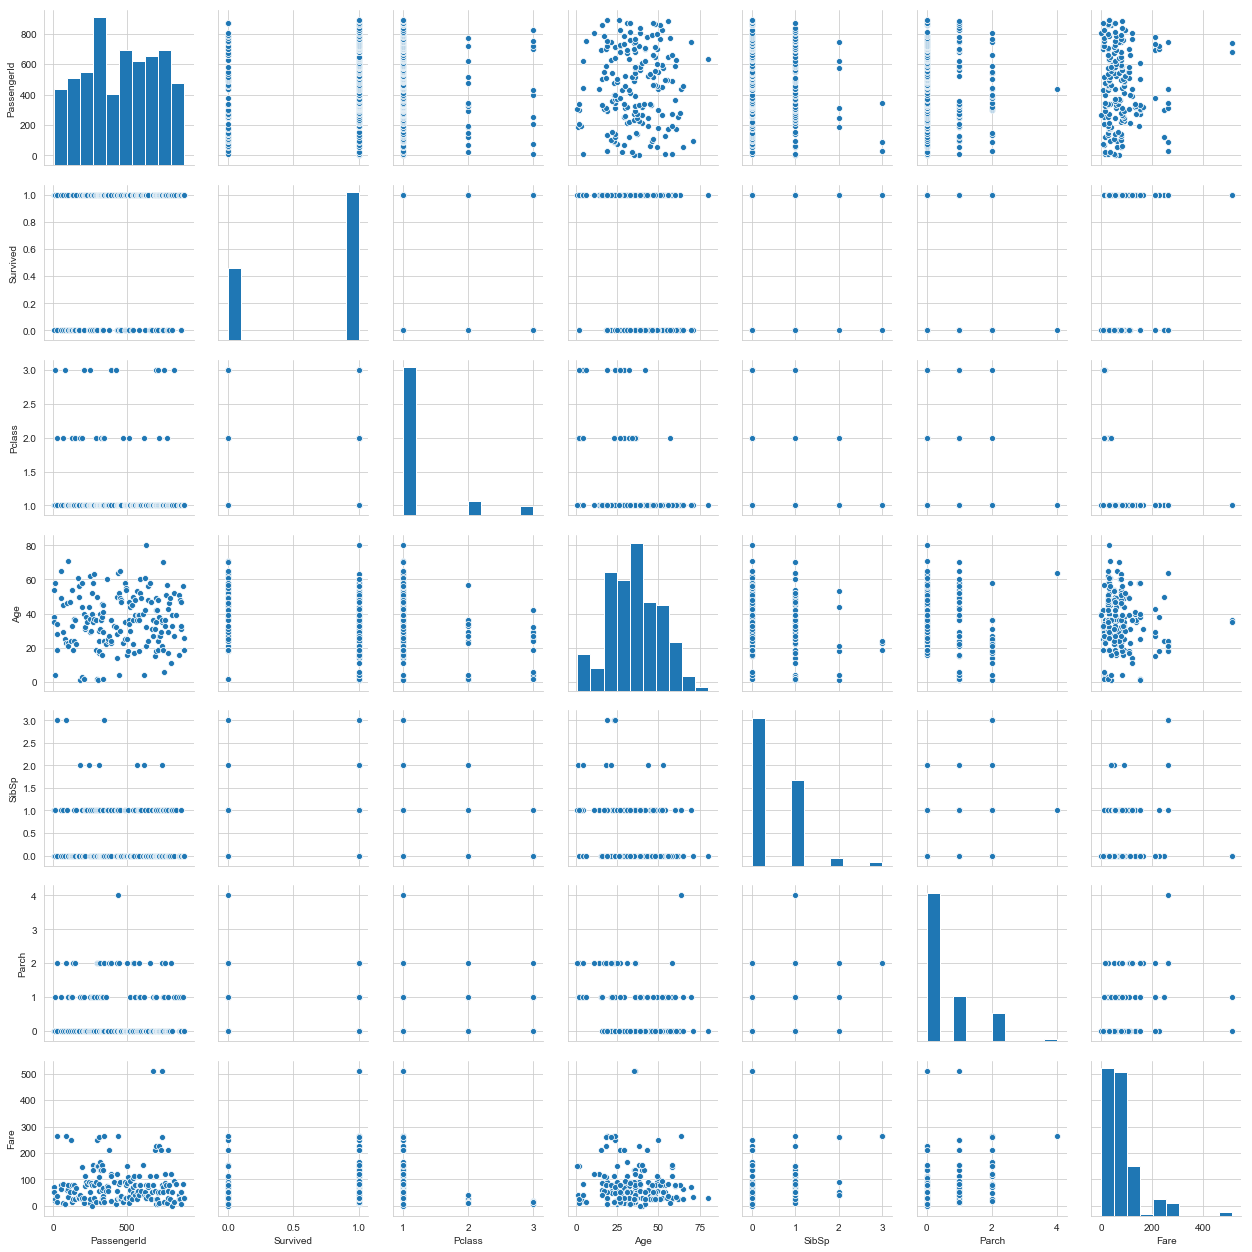

In [10]:
sns.pairplot(train_dat.dropna());

The largest age group on the Titanic based on the data is around 24yrs. old of which there are over 70 individuals.

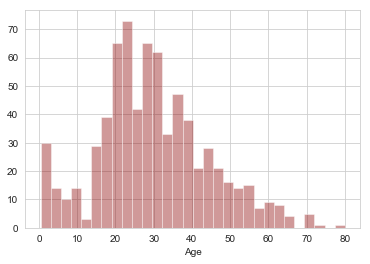

In [11]:
sns.distplot(train_dat['Age'].dropna(),kde=False,color='darkred',bins=30);

The boxplot shows us that the median age in 1st class was around 38 years old.  The median age in 2nd class was around 29 years and the 
median age in 3rd class was around 25 years old.  The youngest age group was in 3rd class.

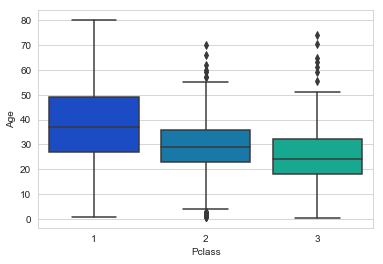

In [12]:
sns.boxplot(x='Pclass',y='Age',data=train_dat,palette='winter')

Missing Values

There are missing values in the following columns: Age, Cabin and Embarked.  I will address the missing values by either substituting the null values with the most common value or the median value for that column.  In addition, where there's nothing that can be done to realistically address the null value without distorting the data I will delete the column. 

In [13]:
train_dat.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
test_dat.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

This dataframe tells us what percentage the missing values are in a specific column, i.e., Cabin has a total of 687 null values in the training dataset which consitutes 77.1% of the data in that column.

In [15]:
total = train_dat.isnull().sum().sort_values(ascending=False)
percent_1 = train_dat.isnull().sum()/train_dat.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The heatmap gives us a visual of the proportion of missing values (yellow lines) in relation to the dataset.  Cabin has alot of missing values.

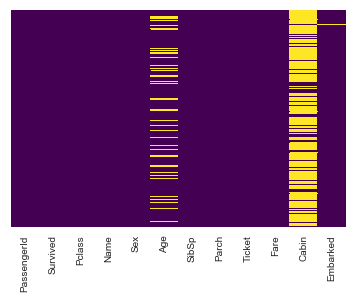

In [16]:
sns.heatmap(train_dat.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Embarked

Embarked has 2 missing values in the training set.  'S' has the most values so I'll assign the 2 missing values an 'S'. 

In [17]:
train_dat['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:

train_dat['Embarked'] = train_dat['Embarked'].fillna('S')

In [19]:
test_dat['Embarked'] = test_dat['Embarked'].fillna('S')

Age

Age in the traing set has 177 missing values out of 891 observations which is 19.9% of the dataset.  I will assign the median age of everyone to the missing values.  

In [20]:
train_dat["Age"] = train_dat["Age"].fillna(value=train_dat["Age"].median())

In [21]:
test_dat["Age"] = test_dat["Age"].fillna(value=test_dat["Age"].median())

Fare


The column Fare has 1 null value.  I'll assign the median Fare value to the null value. 

In [22]:
train_dat["Fare"] = train_dat["Fare"].fillna(value=train_dat["Fare"].median())   

In [23]:
test_dat["Fare"] = test_dat["Fare"].fillna(value=test_dat["Fare"].median())

Cabin

The column Cabin has 687 missing values which is 77.1% of the training dataset.  Not much can be done to rectify the problem
so I will delete the column completely.

In [24]:
train_dat = train_dat.drop('Cabin',axis=1)

In [25]:
test_dat = test_dat.drop('Cabin',axis=1)

Convert Categorical Columns

Non-numerical data needs to be converted numerically so that it can be processed by the models.  For the Name column, not much can be done with the actual names but the listed titles can be grouped accordingly. 

Name

In [26]:
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

def title_number(title):
    if title == 'Mr':
        return 1
    elif title == 'Mrs':
        return 2
    elif title == 'Miss':
        return 3
    elif title == 'Master':
        return 4
    else:
        return 5  

In [27]:
train_dat['get_title'] = train_dat['Name'].apply(get_title).apply(title_number)

In [28]:
test_dat['get_title'] = test_dat['Name'].apply(get_title).apply(title_number)

In [29]:
train_dat['get_title'].value_counts()

1    517
3    182
2    125
4     40
5     27
Name: get_title, dtype: int64

The below bar plot shows that the highest number of individuals that didn't survive had the title Mr. in the Name category.

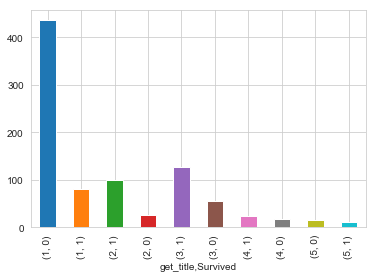

In [30]:
train_dat.groupby('get_title')['Survived'].value_counts().plot(kind='bar')

Sex

Sex column is non-numerical so it needs to be converted.

In [31]:
train_dat['Sex'] = train_dat['Sex'].map({'male':0, 'female':1})

In [32]:
test_dat['Sex'] = test_dat['Sex'].map({'male':0, 'female':1})

Age

The Age feature has numerous unique values so it would be helpful to group the ages.  Based on the below countplot, the largest age group that didn't survive was the age group 27 to 33.  This age group also had the largest number of survivors.

In [33]:
def get_age(various):
    if various <= 11:
        return  0
    elif various <= 18: 
        return 1
    elif (various > 18) & (various <= 22):
        return 2
    elif (various > 22) & (various <= 27):
        return 3
    elif (various > 27) & (various <= 33):
        return 4
    elif (various > 33) & (various <= 40):
        return 5
    elif (various > 40) & (various <= 66):
        return 6
    else:
        return 7

In [34]:
train_dat['get_age'] = train_dat['Age'].apply(get_age)

In [35]:
test_dat['get_age'] = test_dat['Age'].apply(get_age)

In [36]:
train_data= train_dat.copy()

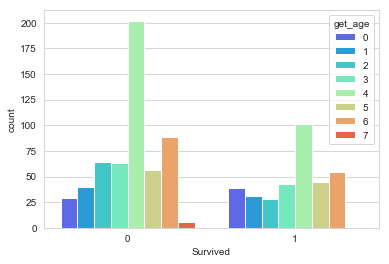

In [37]:
sns.countplot(x='Survived', hue='get_age',data=train_data,palette='rainbow')

In [38]:
ages = pd.get_dummies(train_dat['get_age'],prefix='age',drop_first=True)
ages_test = pd.get_dummies(test_dat['get_age'],prefix='age',drop_first=True)

In [39]:
ages.shape

(891, 7)

In [40]:
ages_test.shape

(418, 7)

In [41]:
train_da = pd.concat([train_dat,ages],axis=1)

In [42]:
test_da= pd.concat([test_dat,ages_test],axis=1)

In [43]:
print(train_da.shape)
print(test_da.shape)

(891, 20)
(418, 19)


Embarked

The column needs to be converted to a numeric value

In [44]:
def get_embark(embark):
    if embark == 'S':
        return 0
    elif embark  == 'C':
        return 1
    else:
        return 2

In [45]:
train_da['Embarked'] = train_da['Embarked'].apply(get_embark)

In [46]:
test_da['Embarked'] = test_da['Embarked'].apply(get_embark)

Create column to determine the number of children that survived.  Based on the below bar plot, luckily more children survived than not.

In [47]:
def get_person(pers):
    age, sex = pers
    
    if age < 16: 
        return 3
    else: 
        return sex

In [48]:
train_da['person'] = train_da[['Age','Sex']].apply(get_person,axis=1)

In [49]:
test_da['person'] = test_da[['Age','Sex']].apply(get_person,axis=1)

In [50]:
train_da['person'].value_counts()

0.0    537
1.0    271
3.0     83
Name: person, dtype: int64

In [51]:
test_da['person'].value_counts()

0.0    247
1.0    139
3.0     32
Name: person, dtype: int64

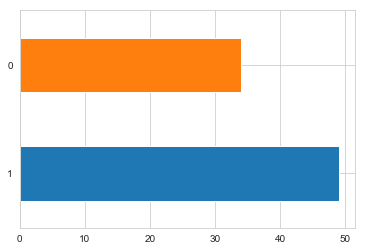

In [52]:
train_da[train_da['person']== 3].Survived.value_counts().plot(kind='barh')

The largest group in the dataset is males.  

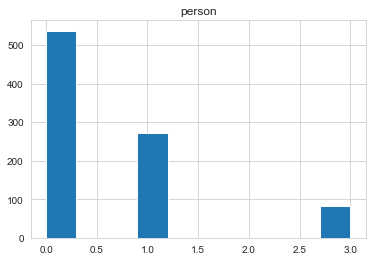

In [53]:
train_da.hist('person');

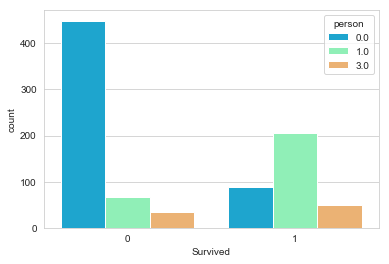

In [54]:
# 0 =didn't survive
# 0.0=Male, 1.0=female
sns.countplot(x='Survived', hue='person',data=train_da,palette='rainbow')

In [55]:
print(train_da.shape)
print(test_da.shape)

(891, 21)
(418, 20)


In [56]:
X_train = train_da.drop(['PassengerId',"Survived",'Name','Age','Ticket','get_age'],axis=1)
Y_train = train_da["Survived"]
X_test  = test_da.drop(['PassengerId','Name','Age','Ticket','get_age'],axis=1).copy()

In [57]:
pd.set_option('display.max_columns', None)  
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,get_title,age_1,age_2,age_3,age_4,age_5,age_6,age_7,person
0,3,0,1,0,7.2500,0,1,0,1,0,0,0,0,0,0.0
1,1,1,1,0,71.2833,1,2,0,0,0,0,1,0,0,1.0
2,3,1,0,0,7.9250,0,3,0,0,1,0,0,0,0,1.0
3,1,1,1,0,53.1000,0,2,0,0,0,0,1,0,0,1.0
4,3,0,0,0,8.0500,0,1,0,0,0,0,1,0,0,0.0


In [58]:
X_test.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,get_title,age_1,age_2,age_3,age_4,age_5,age_6,age_7,person
0,3,0,0,0,7.8292,2,1,0,0,0,0,1,0,0,0.0
1,3,1,1,0,7.0000,0,2,0,0,0,0,0,1,0,1.0
2,2,0,0,0,9.6875,2,1,0,0,0,0,0,1,0,0.0
3,3,0,0,0,8.6625,0,1,0,0,1,0,0,0,0,0.0
4,3,1,1,1,12.2875,0,2,0,1,0,0,0,0,0,1.0


Logisitic Regression

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
y_pred = logreg.predict(X_test)

In [62]:
logreg.score(X_train,Y_train)

0.8215488215488216

In [63]:
y_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

K Nearest Neighbors Classifier

I applied the KNN model to the data and got an accuracy of 87.65% with 3 neighbors.  I increased the number of neighbors to 5 and the accuracy decreased.

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
knn_round = round(knn.score(X_train, Y_train) * 100, 2)
knn_round

87.65

In [66]:
knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
knn_round = round(knn.score(X_train, Y_train) * 100, 2)
knn_round

85.63

This is my first submission to Kaggle and I am new to Data Science.  Any comments on how I can improve my submission are appreciated.  

In [67]:
submission = pd.DataFrame({
        "PassengerId": test_da["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic_kaggle.csv', index=False)

In [68]:
submit = pd.read_csv('titanic_kaggle.csv')
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,1
6,898,1
7,899,0
8,900,1
9,901,0
